# Ultimate Take-home Challenge

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas_profiling as pdprofiling
import warnings

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6

<b>Part 1 ‑ Exploratory data analysis</b><br>
Aggregate login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

Read in the logins file.

In [2]:
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
len(logins_df)

93142

In [4]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


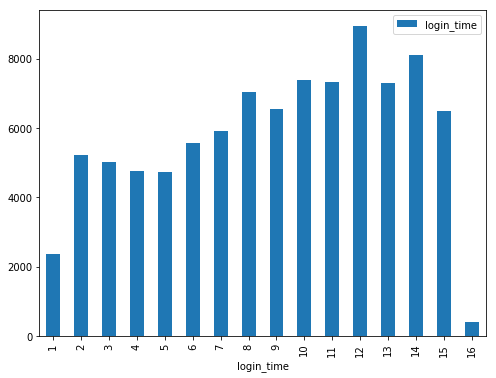

In [5]:
import datetime as dt
logins_df.groupby(logins_df['login_time'].dt.week).count().plot(kind="bar")
plt.show()

<b>Data quality:</b> Looks like first and last week do not have the full data. <br>
The data also shows 1970 as the year. This may be a sign that data integrity was compromised in some way.

Take a quick look at the daily cycles of logins.

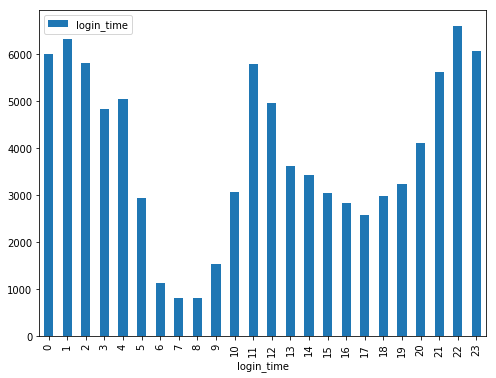

In [6]:
logins_df.groupby(logins_df['login_time'].dt.hour).count().plot(kind="bar")
plt.show()

The most login times tend to occur at night, i.e. after 8pm, with a significant dip in the moring starting around 5am, which again picks up after 10, and reaches another peak around 11 through lunchtime. Afternoons tend to have average login numbers.

Aggregate login counts on 15 min intervals.

In [7]:
logins_df['num_logins'] = 1
quart_hour_intvls = logins_df.groupby(pd.Grouper(key='login_time', freq='15min')).count()
quart_hour_intvls.head(10)

,num_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


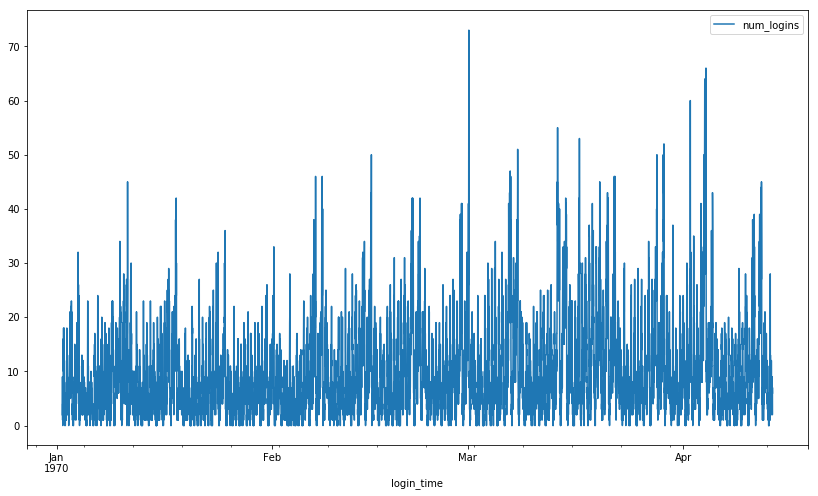

In [8]:
rcParams['figure.figsize'] = 14, 8
quart_hour_intvls.plot()
plt.show()

The data appears to follow daily, weekly and potentially annual cycles (for annual: note that January and February have fewer logins than March and April).There were a couple of peak times: one at the end of February, and another in the beginning of April. These could have been big events, or public transportation disruptions that caused so many users to login.<br>
It would be interesting to see not just the timestamps of logins, but also the geographical coordinates, to have a fuller picture of how demand shifts through time.

<b>Part 2 ‑ Experiment and metrics design</b>
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    - how you will implement the experiment
    - what statistical test(s) you will conduct to verify the significance of the
observation
    - how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

<b>Answer:</b><br>
1. Ultimately, we want to make sure we are not losing money in this situation. I propose the following metric: 

 ```revenue  = sales - toll costs reimbursed``` <br>

2. Experiment design.<br>

    Idea 1. I would randomly select drivers who would have their toll costs reimbursed (treatment group), and would not reimburse toll costs to the other drivers (control group). OR

    Idea 2. Since our cities have opposite circadian rhythms over the weekdays, it may not make a difference to reimburse tolls over the weekdays. I suggest only reimbursing tolls over the weekends, and comparing revenues during the experiment (treatment group) and before it (control group).


I would determine $alpha$ that makes most sense given our data. I would then do a two-sample t-test to see if the 'treatment' group brought in, on average, more revenue per driver. I would also monitor ridership numbers, and do a two-sample t-test on before and after the experiment, to see if ridership numbers increased due to the experiment. <br>

Recommendations:

    * If treatment group made statistically significantly more revenue:
     - Idea 1: I would recommend to extend the offer to the rest of the drivers, and keep monitoring the situation.
     - Idea 2: I would recommend to extend the offer to the rest of the week, and conduct a new experiment, to see if our metric improves.

    * If there was no significant difference between the two groups, but the ridership numbers increased, I would also extend the offer to all drivers / days of week.

    * If treatment group made statistically significantly less money than the control group, I would revert back to drivers being responsible for all toll costs.

    * If the two groups were similar in terms of revenue, and ridership numbers statistics did not change significantly, I would defer to the city operations managers to make the right call.

<i>Caveats:</i>

- We will need to take into account seasonality to really make sure we are controlling for any major differences between the situations before and during the experiment (e.g. if we started running the experiment in March, we may see an uptick in ridership compared to February, but that may not be due to toll reimbursement, but rather due to annual seasonality).
- We will need to keep an eye on toll costs, to make sure our business model works as toll costs change (if they become very low: maybe it's time to reimburse them, or if they become too high: we must stop reimbursing them). 

<b>Part 3 ‑ Predictive modeling </b>

Read in the user data.

In [10]:
import json
with  open("ultimate_data_challenge.json") as f:
    users_js = json.load(f)

users_df = pd.DataFrame(users_js)
users_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [11]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Convert dates into datetime format.

In [12]:
users_df['last_trip_date'], users_df['signup_date'] = pd.to_datetime(users_df['last_trip_date']), pd.to_datetime(users_df['signup_date'])
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
users_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
avg_dist                  41445 non-null float64
avg_rating_by_driver      41445 non-null float64
avg_rating_of_driver      41445 non-null float64
avg_surge                 41445 non-null float64
city                      41445 non-null object
last_trip_date            41445 non-null datetime64[ns]
phone                     41445 non-null object
signup_date               41445 non-null datetime64[ns]
surge_pct                 41445 non-null float64
trips_in_first_30_days    41445 non-null int64
ultimate_black_user       41445 non-null bool
weekday_pct               41445 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


If we just remove all entries that contain null values, we lose over 8,500 users. Let's try to preserve more entries for analysis.

In [14]:
users_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


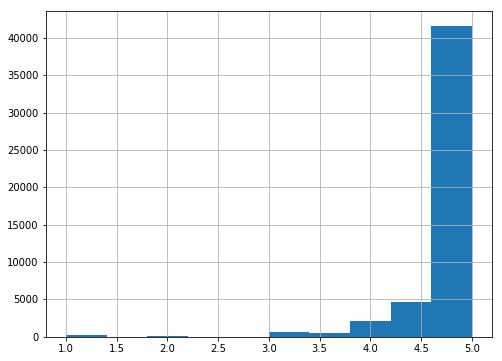

In [15]:
rcParams['figure.figsize'] = 8, 6
users_df['avg_rating_by_driver'].hist()
plt.show()

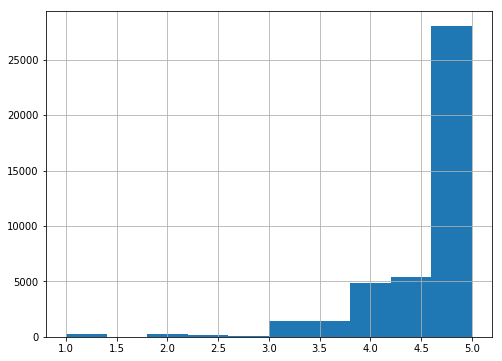

In [16]:
users_df['avg_rating_of_driver'].hist()
plt.show()

Based on the how ratings data is distributed, we are justified to replace missing rating values with averages.

In [17]:
users_df = users_df.fillna(users_df.mean())

In [18]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Let's do a thorough check for any patterns, but also irregularities in the user data, using Pandas Profiling.

In [19]:
pdprofiling.ProfileReport(users_df)

Number of variables,12
Number of observations,50000
Total Missing (%),0.1%
Total size in memory,4.2 MiB
Average record size in memory,89.0 B
Numeric,7
Categorical,2
Boolean,1
Date,2
Text (Unique),0
Rejected,0


We have a potential outlier here: someone who made 125 trips in first month. That seems a little high.

In [20]:
users_df[users_df['trips_in_first_30_days']>90]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
18514,2.02,4.8,5.0,1.12,King's Landing,2014-06-30,iPhone,2014-01-02,14.4,125,True,72.0


The entry makes sense, after all: the user used the service quite a lot during weekdays, and their trips were quite short - could have been someone with a lifestyle requiring a lot of short trips.

Let's determine the start and end date of the last 30 days, to build out our target variable values.

In [21]:
end_date = users_df['last_trip_date'].max()

In [22]:
from datetime import timedelta as td
start_date = end_date - td(days = 30)

Our target variable name is going to be called 'retained'.

In [23]:
users_df['retained'] = ((users_df['last_trip_date'] >= start_date) & (users_df['last_trip_date'] < end_date)).astype(int)

Quick check that all is as expected.

In [24]:
users_df[10:20]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
10,4.28,4.9,5.000000,1.00,Winterfell,2014-05-30,iPhone,2014-01-13,0.0,1,True,100.0,0
11,3.81,5.0,4.000000,1.00,Winterfell,2014-01-10,iPhone,2014-01-06,0.0,3,False,100.0,0
12,20.29,5.0,4.601559,1.00,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0,0
13,3.04,5.0,4.000000,1.38,King's Landing,2014-06-08,iPhone,2014-01-29,50.0,0,False,50.0,1
14,26.01,5.0,4.601559,1.00,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0,0
15,13.20,5.0,4.601559,1.00,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0,0
16,10.86,3.0,5.000000,1.00,King's Landing,2014-06-28,Android,2014-01-11,0.0,1,True,50.0,1
17,2.38,4.8,3.900000,1.00,King's Landing,2014-07-01,iPhone,2014-01-12,0.0,0,True,95.2,0
18,6.83,4.8,4.600000,1.21,King's Landing,2014-06-24,iPhone,2014-01-28,30.8,6,True,80.8,1
19,12.08,5.0,5.000000,1.17,King's Landing,2014-06-03,iPhone,2014-01-02,33.3,0,False,66.7,1


The dataframe looks good. 

What proportion of users who signed up in January, were retained in June?

In [25]:
print("Proportion of users retained: %.2f" %(users_df['retained'].value_counts()[1]*1.0/len(users_df)))

Proportion of users retained: 0.37


Let's eyeball the users for whom we do not have information about whether their phone is iPhone or Android.

In [27]:
users_df[users_df.phone.isna()]['retained'].value_counts()

0    266
1    130
Name: retained, dtype: int64

We will not lose any important information if we just remove all users for whom there's no data about their phones.

In [28]:
users_df.dropna(inplace = True)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
retained                  49604 non-null int32
dtypes: bool(1), datetime64[ns](2), float64(6), int32(1), int64(1), object(2)
memory usage: 4.8+ MB


I am going to use XGBoost classifier to predict which users are retained. I chose that algorithm, because it tends to perform well in classifications on datasets with large numbers of observations. <br>

To be able to apply XGBoost classifier, I first need to make sure variables 'city', 'phone',and 'signup_date' are somehow represented as numbers in our dataset. 

One hot encode: city and phone.

In [30]:
users_for_model = pd.concat([users_df, pd.get_dummies(users_df['city'], drop_first=True, prefix = 'city'), \
                            pd.get_dummies(users_df['phone'], drop_first=True, prefix = 'phone')], axis=1)
users_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
retained                  49604 non-null int32
city_King's Landing       49604 non-null uint8
city_Winterfell           49604 non-null uint8
phone_iPhone              49604 non-null uint8
dtypes: bool(1), datetime64[ns](2), float64(6), int32(1), int64(1), object(2), uint8(3)
memory usage: 4.9+ M

Convert 'signup_date' to numbers representing days of the week when the users signed up.

In [31]:
users_for_model['signup_weekday'] = users_for_model['signup_date'].dt.dayofweek

In [32]:
users_for_model.drop(['city', 'phone', 'last_trip_date', 'signup_date'], inplace = True, axis = 1)
users_for_model.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_King's Landing,city_Winterfell,phone_iPhone,signup_weekday
0,3.67,5.0,4.7,1.10,15.4,4,True,46.2,1,1,0,1,5
1,8.26,5.0,5.0,1.00,0.0,0,False,50.0,0,0,0,0,2
2,0.77,5.0,4.3,1.00,0.0,3,False,100.0,0,0,0,1,0
3,2.36,4.9,4.6,1.14,20.0,9,True,80.0,1,1,0,1,4
4,3.13,4.9,4.4,1.19,11.8,14,False,82.4,0,0,1,0,0


Our dataset is ready for exploratory analysis and modeling!

Knowing how ridesharing works in general, I am going to guess that users don't really like surge pricing.

### Quick exploratory analysis

C:\Users\Dinara\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


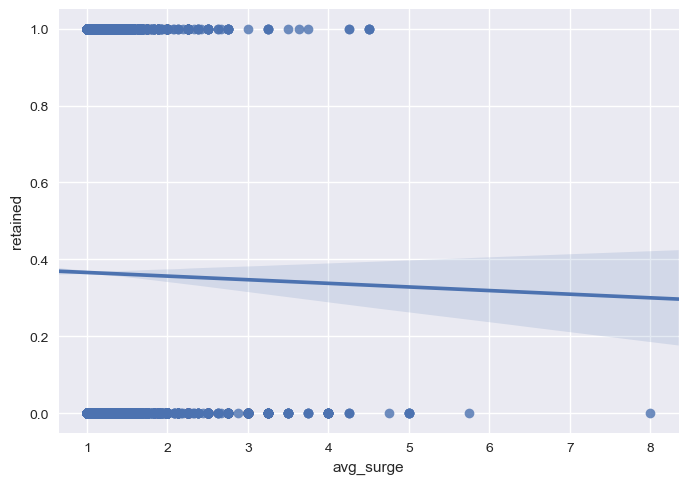

In [34]:
import seaborn as sns
sns.regplot(y=users_for_model['retained'], x=users_for_model['avg_surge'], fit_reg = True)
plt.show()

Indeed!

By the same token, if user has a lot of trips from the get-go, they may be a regular customer.

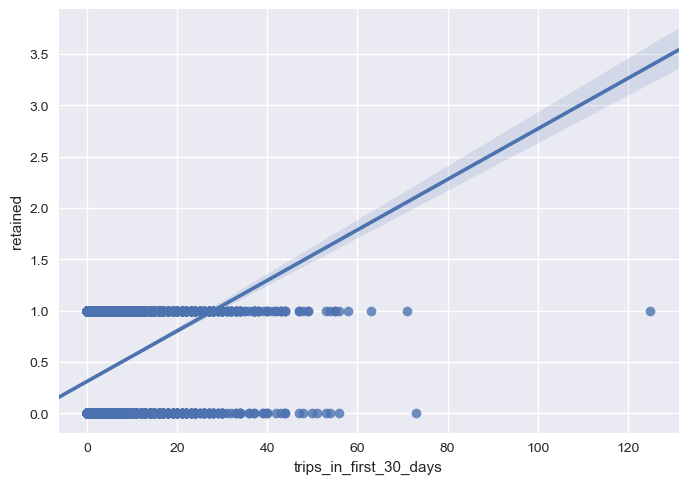

In [35]:
sns.regplot(y=users_for_model['retained'], x=users_for_model['trips_in_first_30_days'], fit_reg = True)
plt.show()

That is also a reasonable idea!

### Building a predictive model

<b>Here's the plan:</b>

Use XGBoost classifier with balance parameter (since our data is a bit unbalanced):
* for that, split data into training and testing sets with stratification
* run XGBoost classifier on the data in its current state (no scaling)
* do the same, only now on scaled data
* if results are not very impressive, do a little parameter tuning
* extract important features, make recommendations 


We will need to know the proportion of negative vs positive values in 'retained', to make sure XGBoost classifier performs well. We'll be stratifying the train-test split, so using that ratio across our models is okay.

In [29]:
balance_neg = users_df['retained'].value_counts()[0]/users_df['retained'].value_counts()[1]
balance_neg

1.7366214277832948

Define predictors: X; and target variable: y.

In [39]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = users_for_model.drop(['retained'], axis = 1), users_for_model['retained']

First try to build an XGBoost classifier: use default parameters and balance parameter

In [40]:
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify = y, random_state = 22, test_size = 0.2)

In [41]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

clf = XGBClassifier(scale_pos_weight=balance_neg)
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)

print("Accuracy (Test) : %.4g" % accuracy_score(test_y, pred_y))
print("AUC Score (Test): %f" % roc_auc_score(test_y, pred_y))
print("Precision (Test): %f" % accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))


Accuracy (Test) : 0.7749
AUC Score (Test): 0.774624
Precision (Test): 0.774922
[[4884 1412]
 [ 821 2804]]


This result is better than random chance.

Let's try the same on scaled data.

In [42]:
sc = StandardScaler()
train_sc_X = sc.fit_transform(train_X)
test_sc_X = sc.transform(test_X)

clf_on_sc = XGBClassifier(scale_pos_weight=balance_neg)
clf_on_sc.fit(train_sc_X, train_y)
pred_y = clf_on_sc.predict(test_sc_X)

print("Accuracy (Test) : %.4g" % accuracy_score(test_y, pred_y))
print("AUC Score (Test): %f" % roc_auc_score(test_y, pred_y))
print("Precision (Test): %f" % accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

Accuracy (Test) : 0.7749
AUC Score (Test): 0.774624
Precision (Test): 0.774922
[[4884 1412]
 [ 821 2804]]


We got the same results with scaled predictors as with unscaled.

Let's take a quick look at parameter importances, and ROC curve.

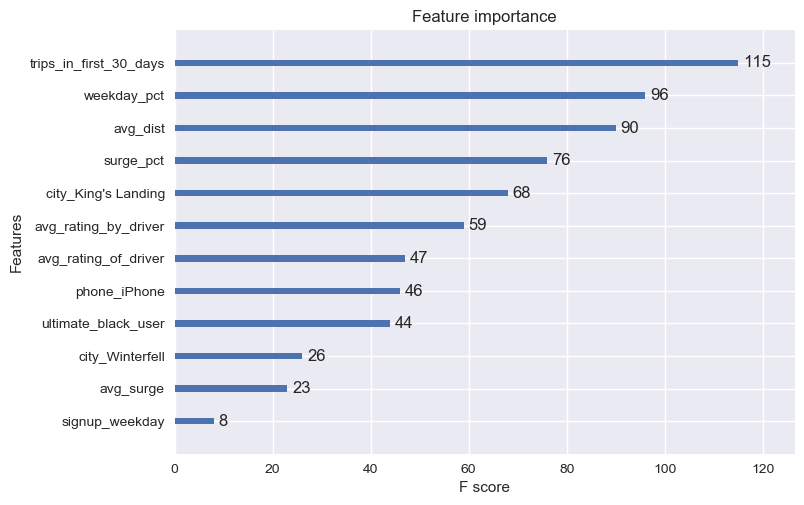

In [43]:
import xgboost
xgboost.plot_importance(clf, ax=None, height=0.2, xlim=None, ylim=None, \
                             title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', \
                             max_num_features=None, grid=True, show_values=True)
plt.show()

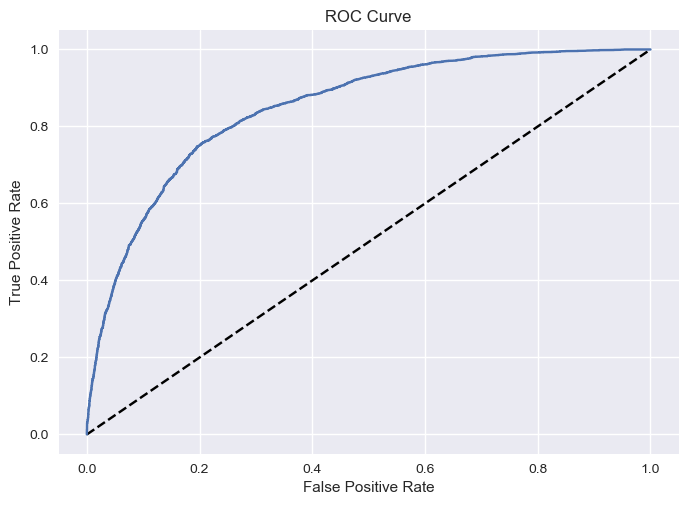

In [44]:
from  sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
pred_prob = clf.predict_proba(test_X)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(test_y, pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Let's take a look at plots of 'retained' plotted against the most important features, according to the classifier.

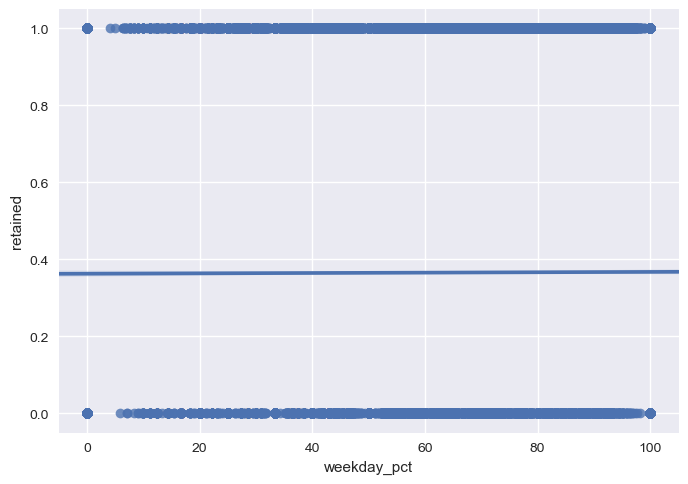

In [45]:
sns.regplot(y=users_for_model['retained'], x=users_for_model['weekday_pct'], fit_reg = True)
plt.show()

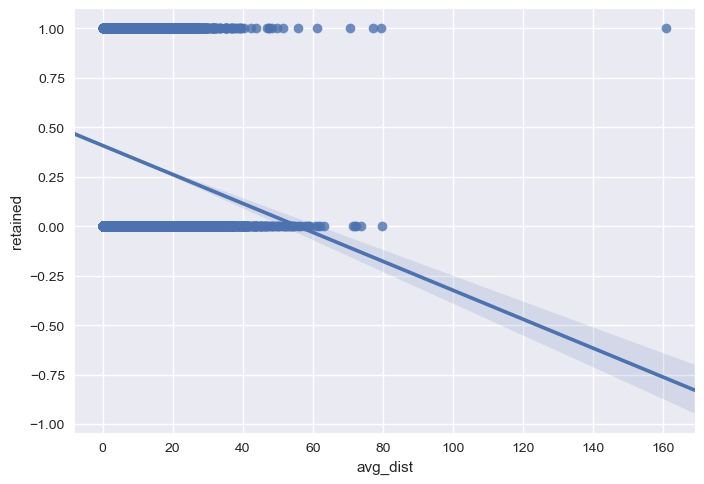

In [46]:
sns.regplot(y=users_for_model['retained'], x=users_for_model['avg_dist'], fit_reg = True)
plt.show()

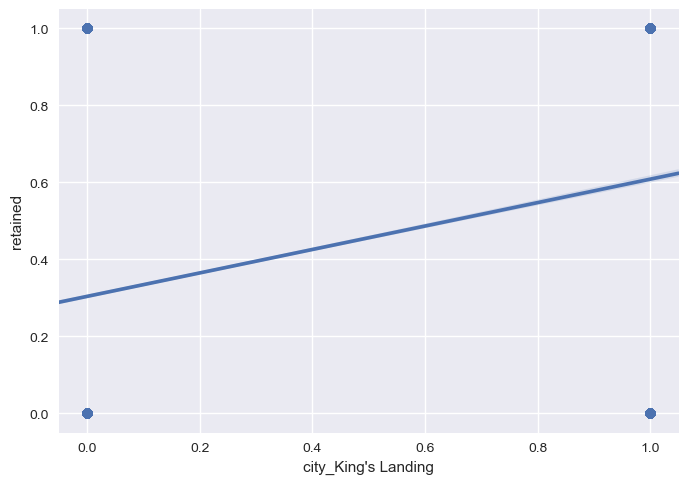

In [48]:
sns.regplot(y=users_for_model['retained'], x=users_for_model["city_King\'s Landing"], fit_reg = True)
plt.show()

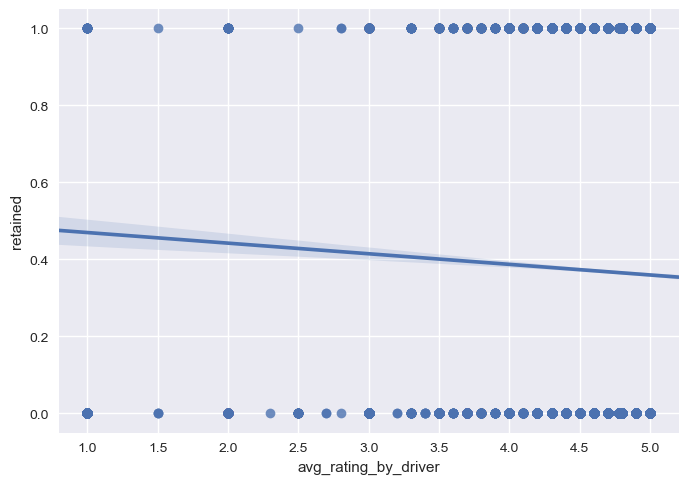

In [49]:
sns.regplot(y=users_for_model['retained'], x=users_for_model['avg_rating_by_driver'], fit_reg = True)
plt.show()

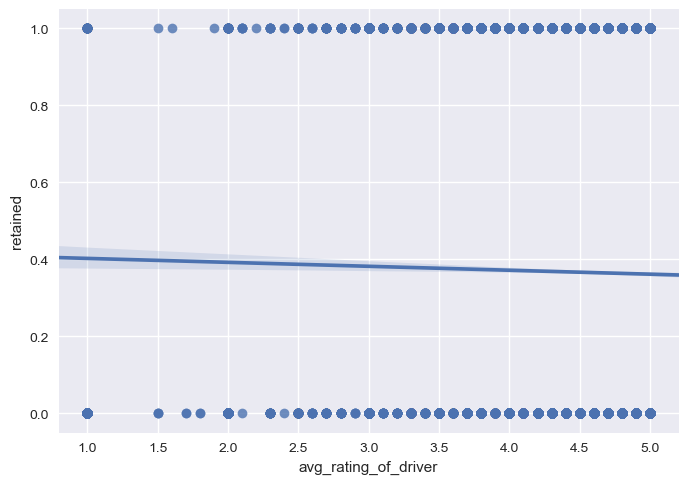

In [50]:
sns.regplot(y=users_for_model['retained'], x=users_for_model['avg_rating_of_driver'], fit_reg = True)
plt.show()

<b>Finally, a quick parameter tuning</b>, to see if there's room for improvement on our model.<br>
We are using GridSearchCV for that.

In [51]:
from sklearn.grid_search import GridSearchCV

Tuning 'max_depth' and 'min_child_weight' to begin with.

In [57]:
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=balance_neg, seed=27), 
 param_grid = param_test1, scoring='roc_auc', cv=5)
gsearch1.fit(train_X, train_y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84030, std: 0.00608, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.84033, std: 0.00607, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.84021, std: 0.00603, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84508, std: 0.00603, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84515, std: 0.00643, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84540, std: 0.00590, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.84449, std: 0.00603, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.84452, std: 0.00591, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.84498, std: 0.00650, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.84057, std: 0.00584, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.84138, std: 0.00600, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.84229, std: 0.00563, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

See how model performs with the tuned parameters.

In [58]:
clf = XGBClassifier(scale_pos_weight=balance_neg, max_depth = 5, min_child_weight = 5)
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)

print("Accuracy (Test) : %.4g" % accuracy_score(test_y, pred_y))
print("AUC Score (Test): %f" % roc_auc_score(test_y, pred_y))
print("Precision (Test): %f" % accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))


Accuracy (Test) : 0.7754
AUC Score (Test): 0.774670
Precision (Test): 0.775426
[[4895 1401]
 [ 827 2798]]


The results improved only slightly.

Last try to tune the model: gamma parameter tuning.

In [60]:
param_test2 = {
 'gamma':[0.1, 0.2, 0.4, 0.8, 1, 1.6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=balance_neg, seed=27), 
 param_grid = param_test2, scoring='roc_auc', cv=5)
gsearch2.fit(train_X, train_y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84531, std: 0.00617, params: {'gamma': 0.1},
  mean: 0.84531, std: 0.00616, params: {'gamma': 0.2},
  mean: 0.84531, std: 0.00612, params: {'gamma': 0.4},
  mean: 0.84527, std: 0.00593, params: {'gamma': 0.8},
  mean: 0.84546, std: 0.00610, params: {'gamma': 1},
  mean: 0.84522, std: 0.00564, params: {'gamma': 1.6}],
 {'gamma': 1},
 0.8454599784192872)

In [61]:
clf = XGBClassifier(scale_pos_weight=balance_neg, max_depth = 5, min_child_weight = 5, gamma = 1)
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)

print("Accuracy (Test) : %.4g" % accuracy_score(test_y, pred_y))
print("AUC Score (Test): %f" % roc_auc_score(test_y, pred_y))
print("Precision (Test): %f" % accuracy_score(test_y, pred_y))
print(confusion_matrix(test_y, pred_y))

Accuracy (Test) : 0.7768
AUC Score (Test): 0.775840
Precision (Test): 0.776837
[[4908 1388]
 [ 826 2799]]


It seems our model is improving slightly, but no major strides are being made.

### Parameter importance from the tuned model:

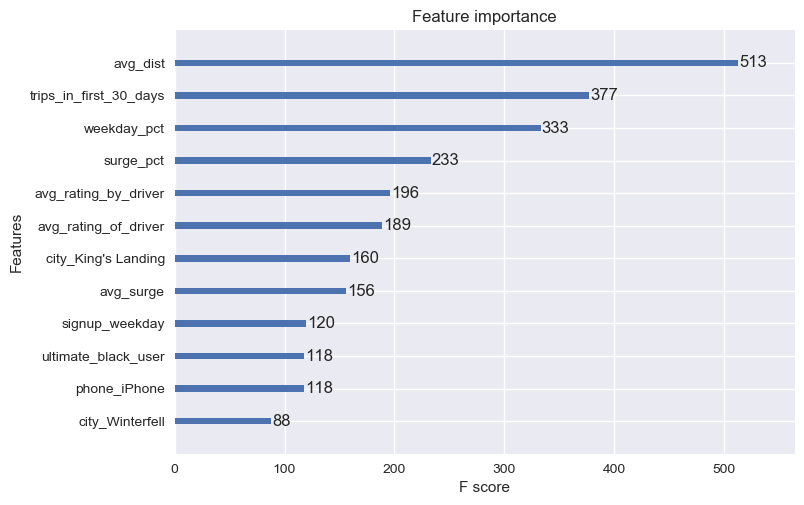

In [62]:
xgboost.plot_importance(clf, ax=None, height=0.2, xlim=None, ylim=None, \
                             title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', \
                             max_num_features=None, grid=True, show_values=True)
plt.show()

# Recommendations:
<b>To make sure a user is retained on month 6 after signup:</b>

1. Encourage short distance rides: maybe have short-term special deals for them.
1. Make sure they take as many rides as possible in their first month of membership: run campaigns that encourage rides in first 30 days.
1. Market to people who are likely to use Ultimate for their weekday commutes and errands.
1. Try to limit surge pricing (If it is worth it for Ultimate to change its surge pricing policies is a big question!).